In [6]:
import xarray as xr
import matplotlib as mpl
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import math
import numpy as np
# import cartopy.feature as cfeature
import cartopy.util as cutil
import cartopy.mpl.ticker as cticker

from matplotlib.animation import FuncAnimation

from netCDF4 import Dataset
import h5py
from datetime import datetime as dt

In [3]:
path = "H:/Summer24-25/Jupyter/Proper/"
file = path + "o3_Amon_CESM2-WACCM_ssp126.nc"
print(file)


H:/Summer24-25/Jupyter/Proper/o3_Amon_CESM2-WACCM_ssp126.nc


In [4]:
ds = xr.open_dataset(file, engine="netcdf4")
ds

C:\Python312\Lib\site-packages\xarray\conventions.py:289: SerializationWarning: variable 'o3' has multiple fill values {np.float32(1e+20), np.float64(1e+20)} defined, decoding all values to NaN.
  var = coder.decode(var, name=name)


<xarray.Dataset> Size: 3GB
Dimensions:    (time: 600, plev: 19, lat: 192, lon: 288, nbnd: 2)
Coordinates:
  * lat        (lat) float64 2kB -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
  * lon        (lon) float64 2kB 0.0 1.25 2.5 3.75 ... 355.0 356.2 357.5 358.8
  * plev       (plev) float64 152B 1e+05 9.25e+04 8.5e+04 ... 1e+03 500.0 100.0
  * time       (time) object 5kB 2015-01-15 12:00:00 ... 2064-12-15 12:00:00
Dimensions without coordinates: nbnd
Data variables:
    o3         (time, plev, lat, lon) float32 3GB ...
    time_bnds  (time, nbnd) object 10kB ...
    lat_bnds   (lat, nbnd) float32 2kB ...
    lon_bnds   (lon, nbnd) float32 2kB ...
Attributes: (12/45)
    Conventions:            CF-1.7 CMIP-6.2
    activity_id:            ScenarioMIP
    branch_method:          standard
    branch_time_in_child:   735110.0
    branch_time_in_parent:  735110.0
    case_id:                55
    ...                     ...
    sub_experiment_id:      none
    table_id:               Amon
    tracking_id:            hdl:21.14100/a75230b6-a50e-4c76-91c1-6367469df58a
    variable_id:            o3
    variant_info:           CMIP6 CESM2 future scenario SSP1-2.6, years 2015-...
    variant_label:          r1i1p1f1

# o3 by time

CPU times: total: 1min 49s
Wall time: 2min 2s


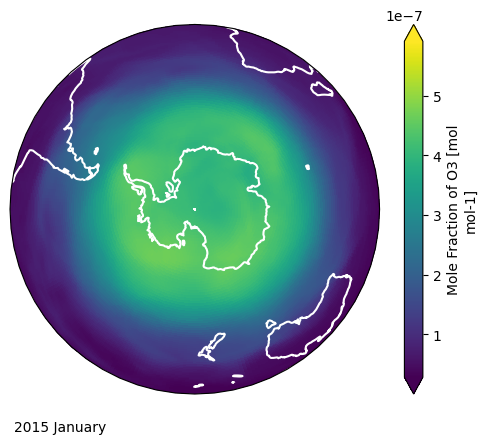

In [11]:
%%time
##un normalised colours + coasts --> GIF
pressure = 20000 # req. pressure level in Pa --> 200hPa
frames = ds.o3.time.size

fig = plt.figure()

fig.suptitle("Concentration of Mole Fraction of O3 at %spa" %pressure)
def animate(num):
    fig.clear()
    ax = plt.axes(projection=ccrs.Orthographic(central_longitude=0.0, central_latitude=-90))
    ds.o3.isel(time=num).sel(plev=pressure).plot(ax=ax, transform=ccrs.PlateCarree(), robust=True)
    date = dt.strptime(str(ds.time[num].values), '%Y-%m-%d %H:%M:%S')
    formatted = date.strftime("%Y %B")
    ax.text(0.01, -0.1, formatted, ha='left', transform=ax.transAxes)
    ax.coastlines(color='w', lw=1.5, resolution='110m')
    ax.set_title('')
    

ani = FuncAnimation(fig, animate, interval=200, frames=ds.o3.time.size)
ani.save("o3_notNormCoasts_full.gif", writer="pillow")

CPU times: total: 1min 44s
Wall time: 2min


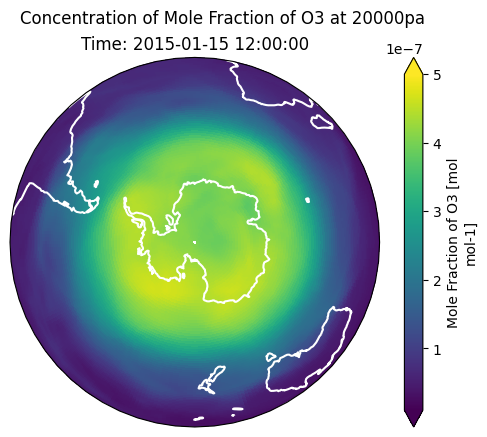

In [8]:
%%time
## normalised colours + coasts
pressure = 20000 # req. pressure level in Pa --> 200hPa
norm = mpl.colors.Normalize(vmin=(10**-8), vmax=(5*10**-7))
frames = math.floor(ds.o3.time.size/2)

fig = plt.figure()
ax = plt.axes(projection=ccrs.Orthographic(central_longitude=0.0, central_latitude=-90))

fig.suptitle("Concentration of Mole Fraction of O3 at %spa" %pressure)
ds.o3.isel(time=0).sel(plev=pressure).plot(ax=ax, transform=ccrs.PlateCarree(), norm=norm, extend='both')
def animate(num):
    ax.clear()
    ds.o3.isel(time=num).sel(plev=pressure).plot(ax=ax, transform=ccrs.PlateCarree(), norm=norm, extend='both')
    ax.collections[-1].colorbar.remove()
    ax.set_title("Time: %s" %(ds.o3.isel(time=num)['time'].values))
    ax.coastlines(color='w', lw=1.5, resolution='110m')
    

anim = FuncAnimation(fig, animate, interval=200, frames=ds.o3.time.size)
anim.save("o3_normCoasts_full.gif", writer='pillow')

CPU times: total: 1min 38s
Wall time: 1min 54s


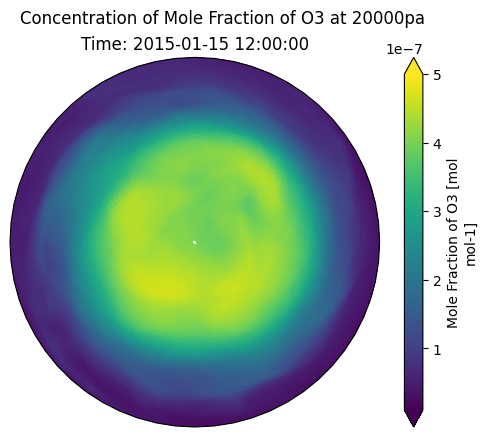

In [9]:
%%time
## normalised colours no coast
pressure = 20000 # req. pressure level in Pa --> 200hPa
norm = mpl.colors.Normalize(vmin=(10**-8), vmax=(5*10**-7))
frames = math.floor(ds.o3.time.size/2)
cmap='viridis'

fig = plt.figure()
ax = plt.axes(projection=ccrs.Orthographic(central_longitude=0.0, central_latitude=-90))

fig.suptitle("Concentration of Mole Fraction of O3 at %spa" %pressure)
ds.o3.isel(time=0).sel(plev=pressure).plot(ax=ax, transform=ccrs.PlateCarree(), norm=norm, extend='both', cmap=cmap)
def animate(num):
    ax.clear()
    ds.o3.isel(time=num).sel(plev=pressure).plot(ax=ax, transform=ccrs.PlateCarree(), norm=norm, extend='both', cmap=cmap)
    ax.collections[-1].colorbar.remove()
    ax.set_title("Time: %s" %(ds.o3.isel(time=num)['time'].values))

anim = FuncAnimation(fig, animate, interval=200, frames=ds.o3.time.size)
anim.save("o3_normNotCoast_full.gif", writer="pillow")

CPU times: total: 9min 25s
Wall time: 9min 27s


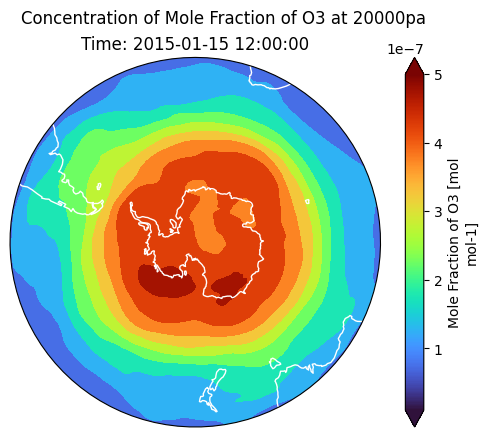

In [10]:
%%time
#contour map
pressure = 20000 # req. pressure level in Pa --> 200hPa
norm = mpl.colors.Normalize(vmin=(10**-8), vmax=(5*10**-7))
frames = math.floor(ds.o3.time.size/2)

theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpl.path.Path(verts * radius + center)

fig = plt.figure()
ax=plt.axes(projection=ccrs.SouthPolarStereo(central_longitude=0.0))

fig.suptitle("Concentration of Mole Fraction of O3 at %spa" %pressure)

ds.o3.isel(time=0).sel(plev=pressure).plot(ax=ax, transform=ccrs.PlateCarree(), cmap='turbo', norm=norm, extend="both")

def animate(num):
    ax.clear()
    data, lons = cutil.add_cyclic_point(ds.o3.isel(time=num).sel(plev=pressure), coord=ds.lon)
    cs = ax.contourf(lons, ds.lat, data, levels=12, transform=ccrs.PlateCarree(), cmap='turbo', norm=norm, extend='both')
    ax.coastlines(color='w') # comment out to remove coastlines
    ax.set_title("Time: %s" %(ds.o3.isel(time=num)['time'].values))
    ax.set_extent([0,360, -90, -30], ccrs.PlateCarree())
    ax.set_boundary(circle, transform=ax.transAxes)


anim = FuncAnimation(fig, animate, interval = 200, frames=ds.o3.time.size)

anim.save("o3_contour_full.gif", writer='pillow')

# o3 by time, subplot by plev

CPU times: total: 3.25 s
Wall time: 4.58 s


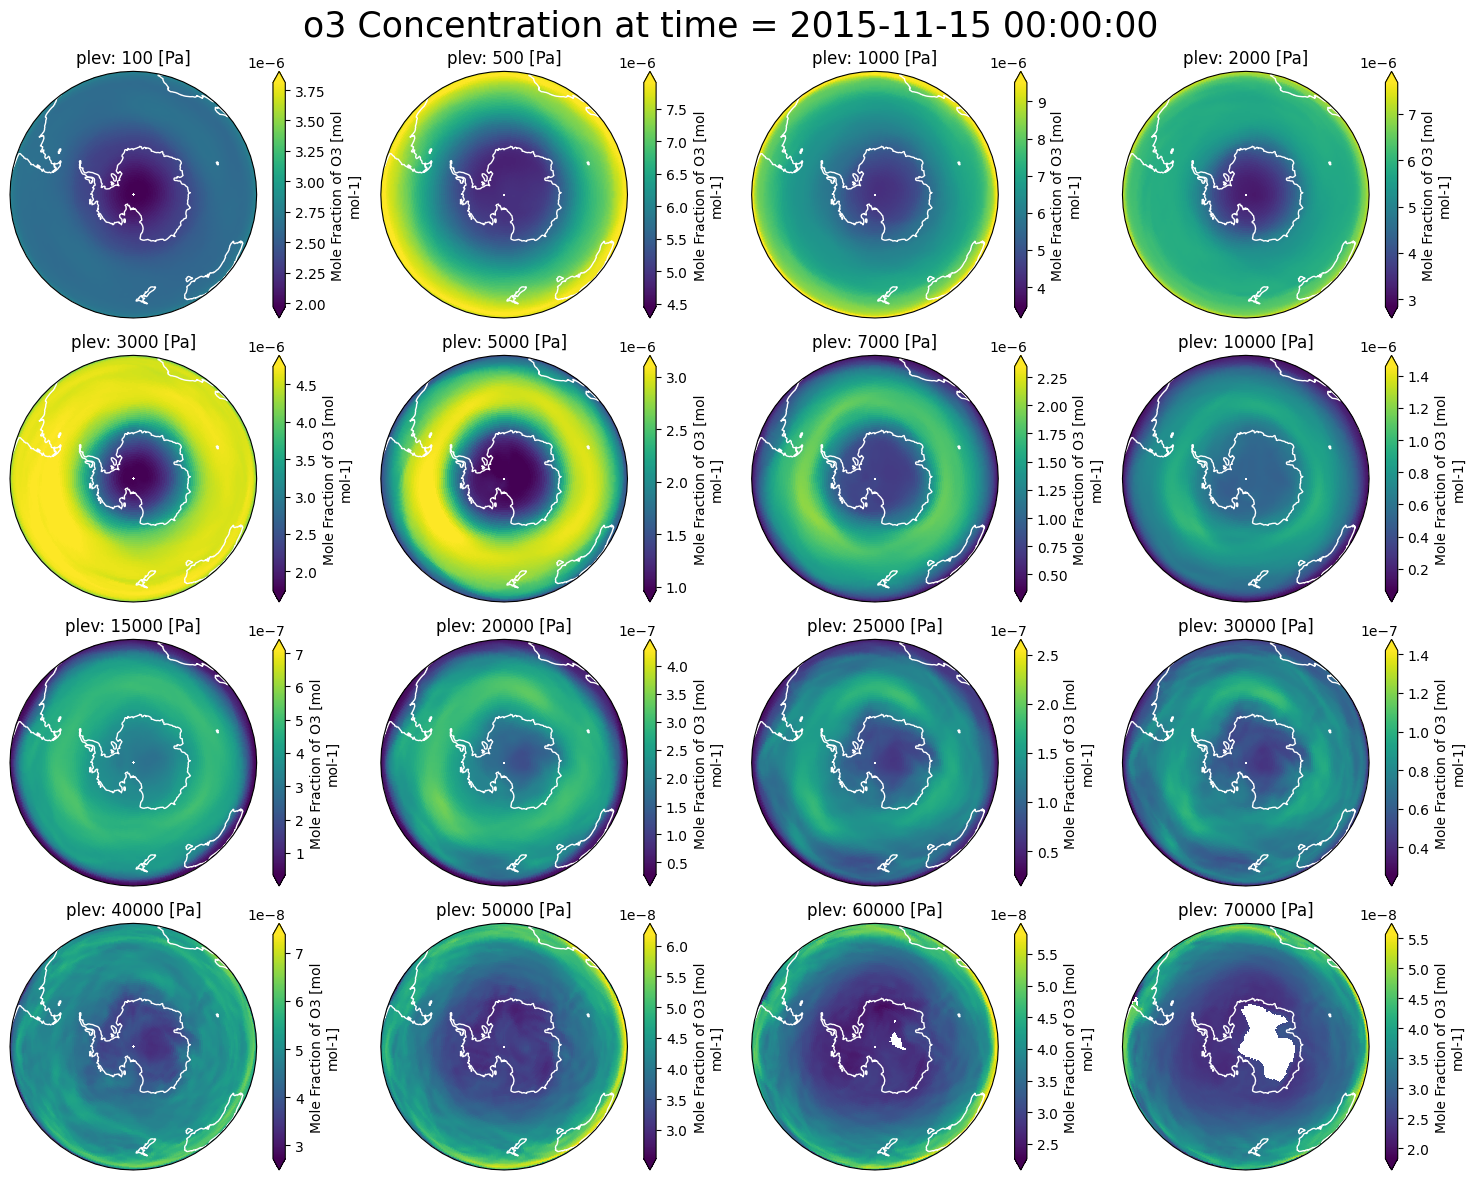

In [123]:
%%time
# at time = nTime, all plev (no anim!!!)
fig, axs = plt.subplots(4,4, figsize=(15,12), layout='tight', subplot_kw=
                        {'projection': ccrs.NearsidePerspective(central_longitude=0.0, central_latitude=-90)})
nTime = 10

fig.suptitle("o3 Concentration at time = %s" %ds.time.isel(time=nTime)['time'].values, size=25)

lev=18
for r, row in enumerate(axs):
    for c, ax in enumerate(row):
        ds.o3.isel(time=nTime, plev=lev).plot(ax=ax, transform=ccrs.PlateCarree(), robust=True)
        ax.set_title("plev: %.f [Pa]" %ds.plev.isel(plev=lev)['plev'].values)
        ax.coastlines(resolution='110m', color='w')
        lev-=1

plt.savefig("o3_byPlev.png")

CPU times: total: 2.58 s
Wall time: 3.25 s


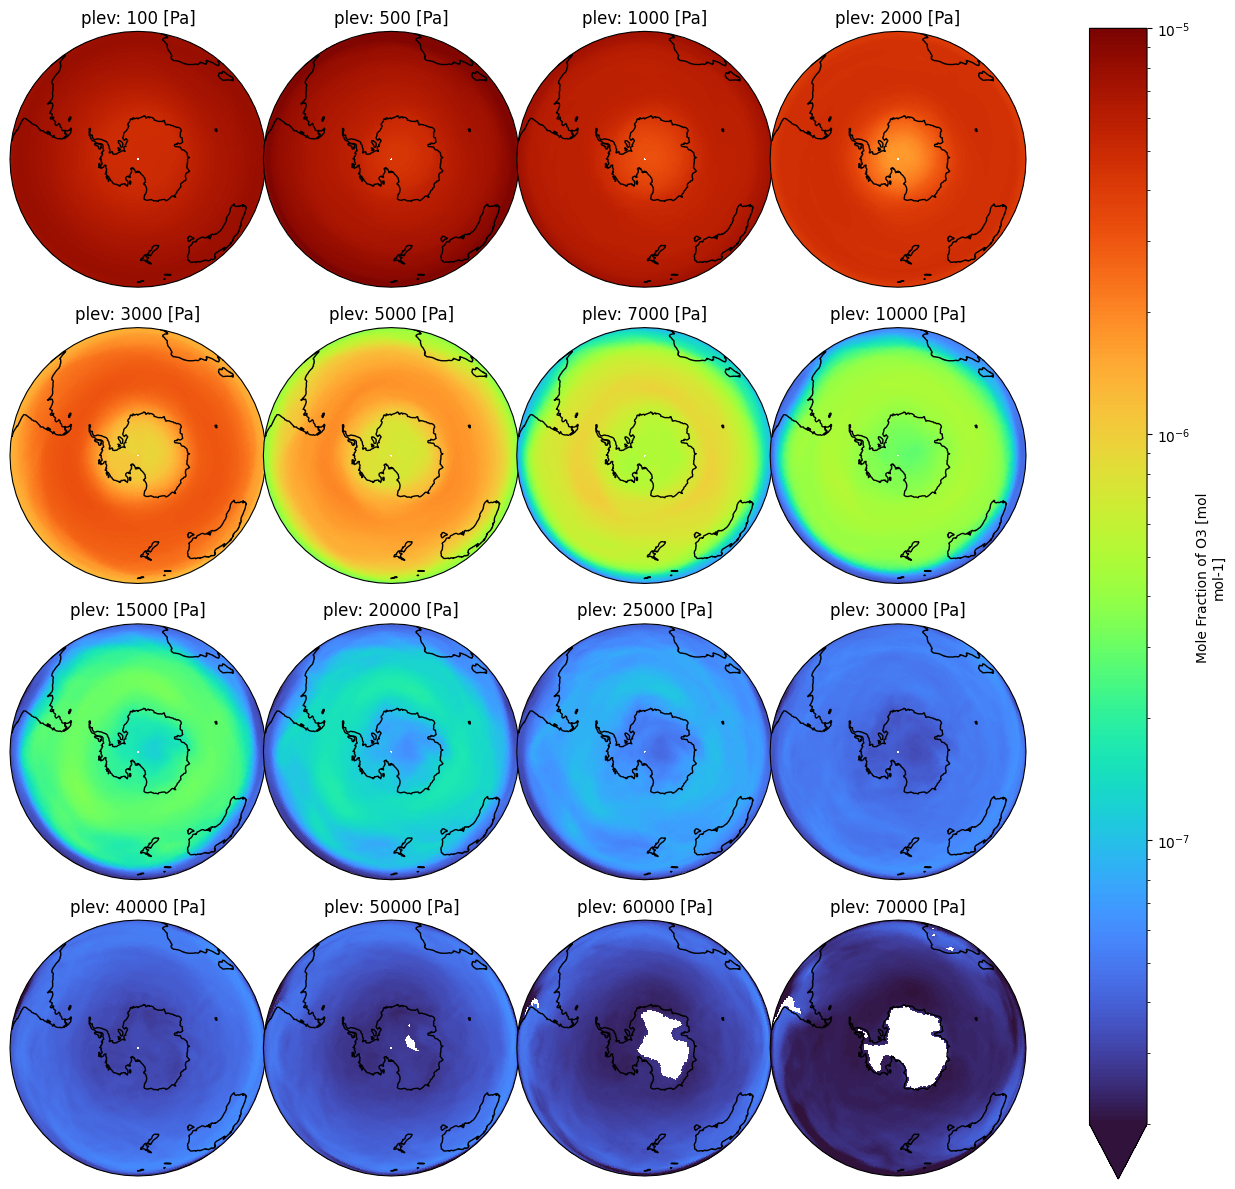

In [138]:
%%time
# # at time = nTime, facets, normalized --> cant use anim with facets
nTime = 10
fig.suptitle("o3 Concentration at time = %s" %ds.time.isel(time=nTime)['time'].values, size=25)

norm = mpl.colors.LogNorm(vmin=(2*10**-8), vmax=(10**-5))
pnum = np.arange(2, 18, 1)[::-1]

p = ds.o3.isel(time=nTime).isel(plev=pnum).plot(
    transform=ccrs.PlateCarree(),
    col="plev", col_wrap=4, norm=norm, cmap='turbo', 
    subplot_kws={"projection": ccrs.Orthographic(0,-90)},
)

lev = 18
for ax in p.axs.flat:
    ax.coastlines()
    ax.set_title("plev: %.f [Pa]" %ds.plev.isel(plev=lev)['plev'].values)
    lev-=1

plt.savefig("o3_byPlev_combined.png")

CPU times: total: 3.73 s
Wall time: 4.98 s


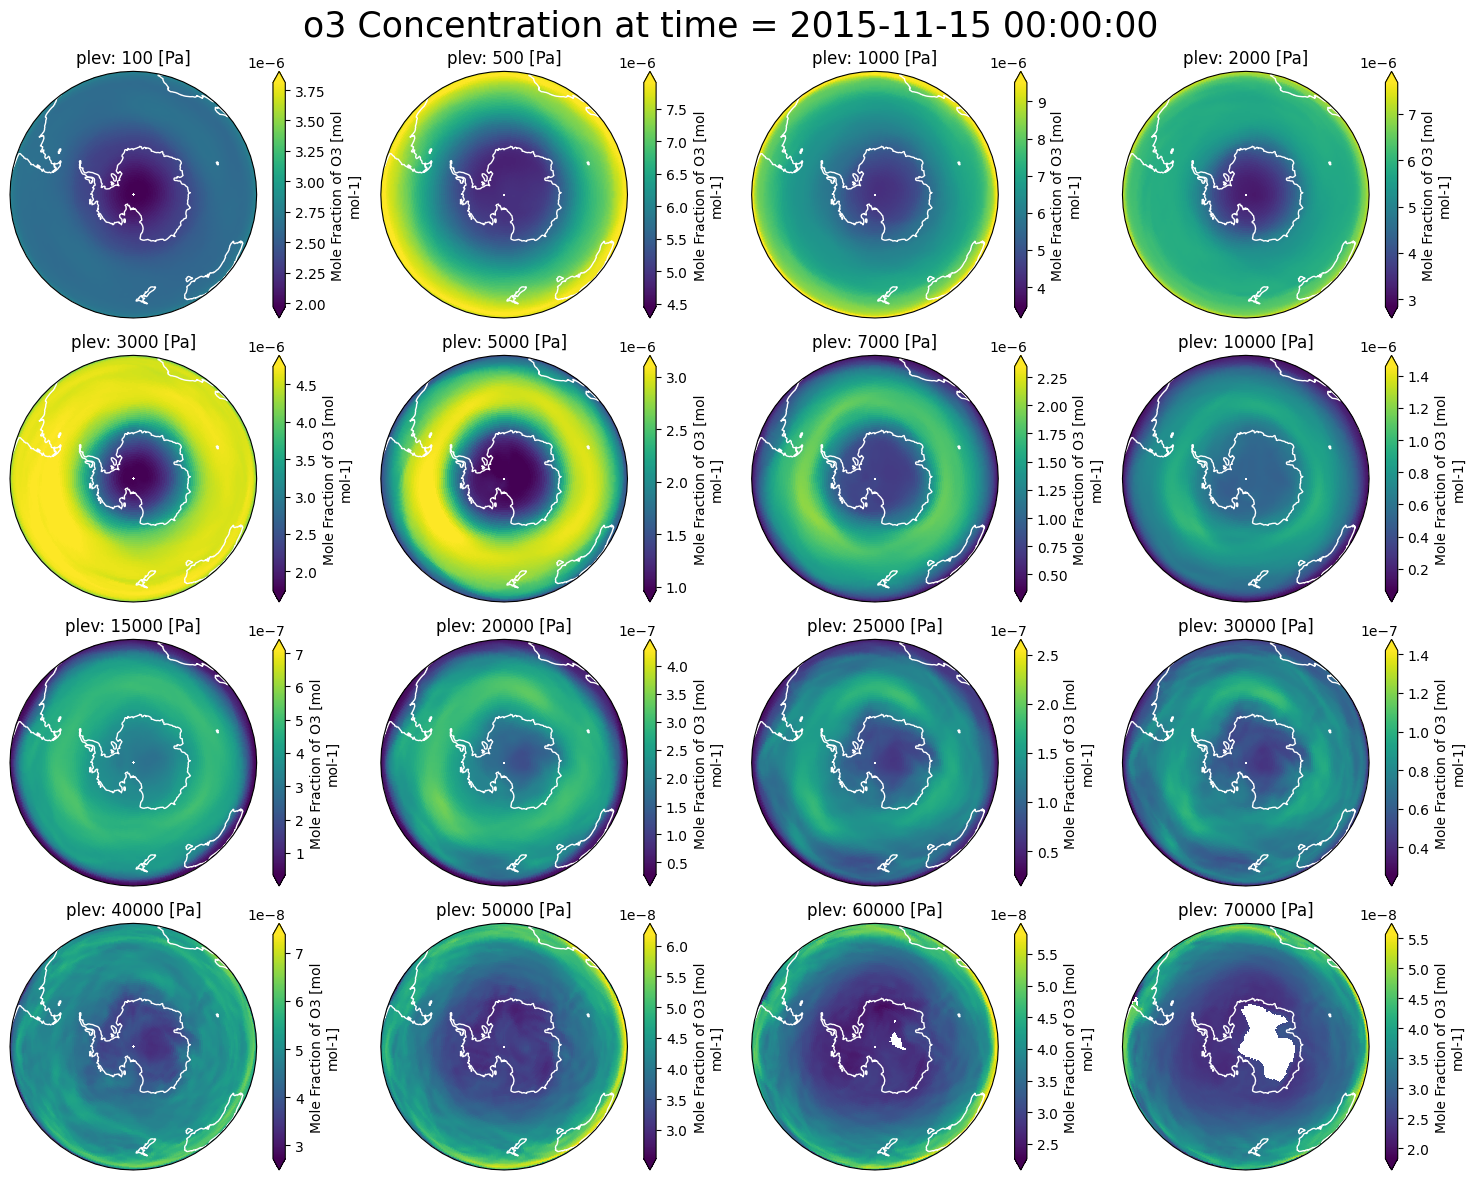

In [62]:
%%time
# at time = nTime, all plev (no anim!!!)
fig, axs = plt.subplots(4,4, figsize=(15,12), layout='tight', subplot_kw=
                        {'projection': ccrs.NearsidePerspective(central_longitude=0.0, central_latitude=-90)})
nTime = 10

fig.suptitle("o3 Concentration at time = %s" %ds.time.isel(time=nTime)['time'].values, size=25)

lev=18
for r, row in enumerate(axs):
    for c, ax in enumerate(row):
        ds.o3.isel(time=nTime, plev=lev).plot(ax=ax, transform=ccrs.PlateCarree(), robust=True)
        ax.set_title("plev: %.f [Pa]" %ds.plev.isel(plev=lev)['plev'].values)
        ax.coastlines(resolution='110m', color='w')
        lev-=1

plt.savefig("o3_byPlev.png")

CPU times: total: 11.1 s
Wall time: 11.7 s


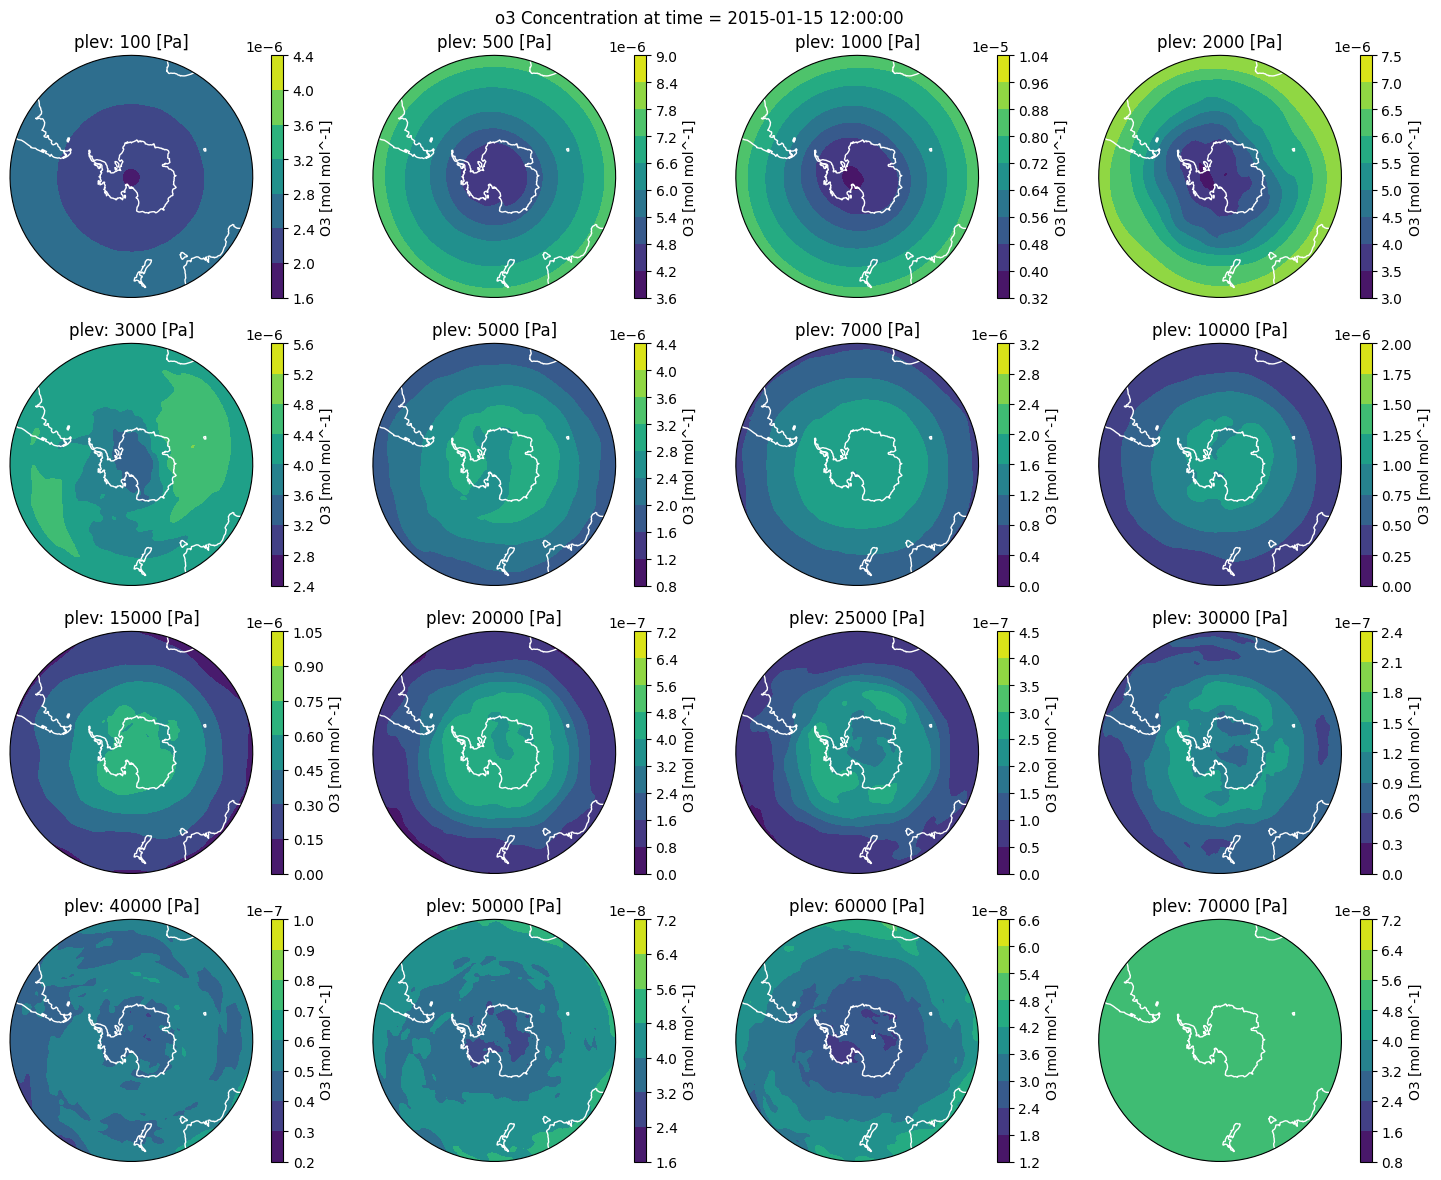

In [232]:
%%time
# at time = nTime, all plev - contour (no anim!!!)
fig, axs = plt.subplots(4,4, figsize=(15,12), layout='tight', subplot_kw=
                        {'projection': ccrs.SouthPolarStereo(central_longitude=0)})
nTime = 0

theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpl.path.Path(verts * radius + center)

fig.suptitle("o3 Concentration at time = %s" %ds.time.isel(time=nTime)['time'].values)

lev=18
for r, row in enumerate(axs):
    for c, ax in enumerate(row):
        data, lons = cutil.add_cyclic_point(ds.o3.isel(time=nTime, plev=lev), coord=ds.lon)
        cs = ax.contourf(lons, ds.lat, data, transform=ccrs.PlateCarree())
        plt.colorbar(cs, label = 'O3 [mol mol^-1]')
        ax.set_title("plev: %.f [Pa]" %ds.plev.isel(plev=lev)['plev'].values)
        ax.coastlines(resolution='110m', color='w')
        ax.set_extent([0,360, -90, -30], ccrs.PlateCarree())
        ax.set_boundary(circle, transform=ax.transAxes)
        lev -= 1

plt.savefig("o3_byPlev_contour.png")

CPU times: total: 9.92 s
Wall time: 9.93 s


Text(0.5, 0.98, 'o3 Concentration at time = 2015-04-15 00:00:00')

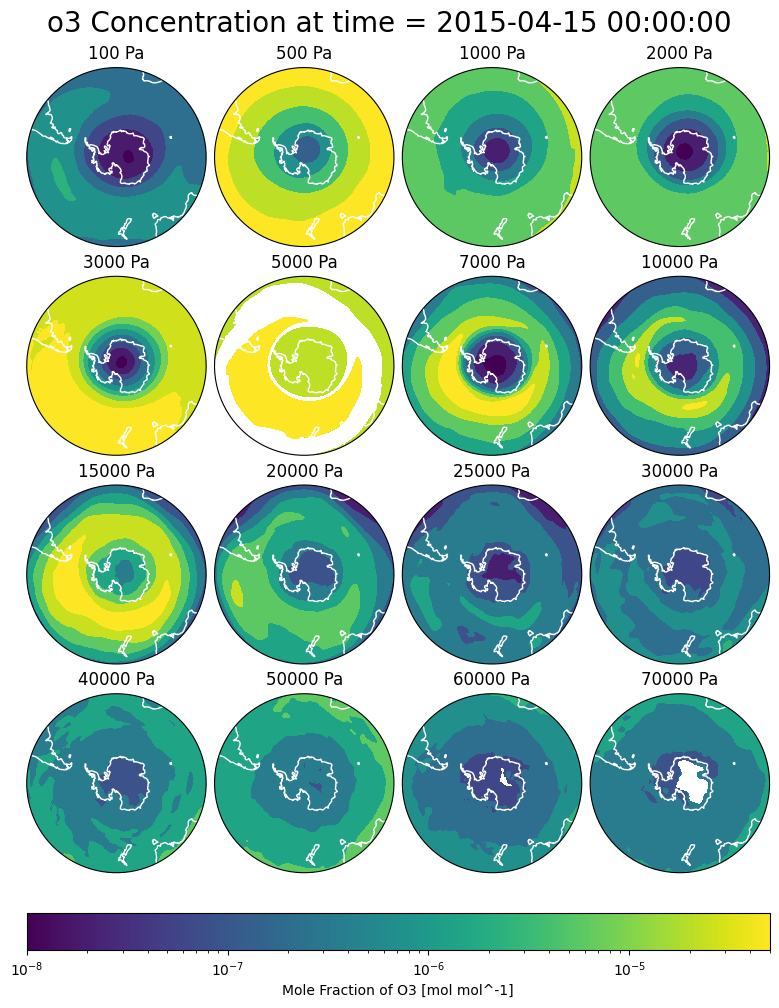

In [13]:
%%time

# at time = n, all plev (color plot), animated by time
fig, axs = plt.subplots(4,4, figsize=(8,10), layout='compressed', subplot_kw=
                        {'projection': ccrs.SouthPolarStereo(central_longitude=0.0)})

frames = math.floor(ds.o3.time.size/2)
norm = mpl.colors.LogNorm(vmin=(10**-8), vmax=(5*10**-5))
cmap = 'viridis'

theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpl.path.Path(verts * radius + center)

plt.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap), ax=axs, location='bottom', label="Mole Fraction of O3 [mol mol^-1]")

# def update(num):
#     lev=18
#     for r, row in enumerate(axs):
#         for c, ax in enumerate(row):
#             ax.clear()
#             data, lons = cutil.add_cyclic_point(ds.o3.isel(time=num, plev=lev), coord=ds.lon)
#             cs = ax.contourf(lons, ds.lat, data, transform=ccrs.PlateCarree(), cmap=cmap)
#             ax.set_title("%.f Pa" %ds.plev.isel(plev=lev).values)
#             ax.coastlines(resolution='110m', color='w')
#             lev -= 1
#             ax.set_extent([0,360, -90, -30], ccrs.PlateCarree())
#             ax.set_boundary(circle, transform=ax.transAxes)
#     fig.suptitle("o3 Concentration at time = %s" %ds.time.isel(time=num).values, size=20)


# anim = FuncAnimation(fig=fig, func=update, frames=5, interval=200, repeat=True)

# anim.save("o3_manyContourTEST.gif", writer='pillow')


lev=18
for r, row in enumerate(axs):
    for c, ax in enumerate(row):
        ax.clear()
        data, lons = cutil.add_cyclic_point(ds.o3.isel(time=9, plev=lev), coord=ds.lon)
        cs = ax.contourf(lons, ds.lat, data, transform=ccrs.PlateCarree(), cmap=cmap, extend='both')
        ax.set_title("%.f Pa" %ds.plev.isel(plev=lev).values)
        ax.coastlines(resolution='110m', color='w')
        lev -= 1
        ax.set_extent([0,360, -90, -30], ccrs.PlateCarree())
        ax.set_boundary(circle, transform=ax.transAxes)
fig.suptitle("o3 Concentration at time = %s" %ds.time.isel(time=3).values, size=20)

CPU times: total: 10min 21s
Wall time: 10min 24s


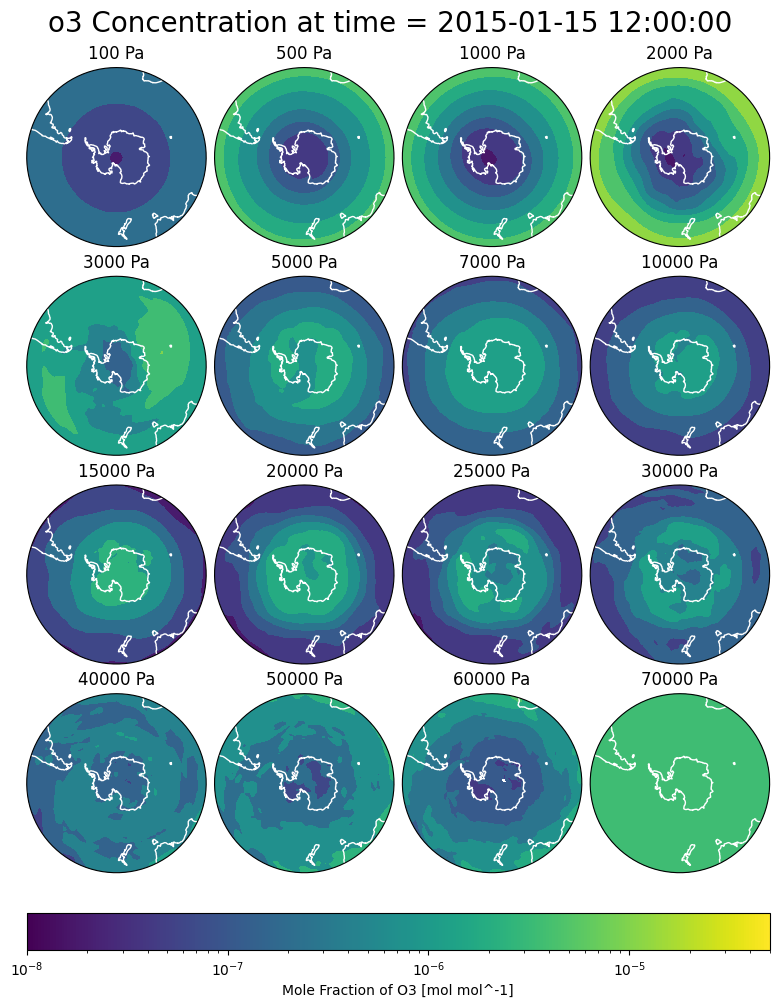

In [236]:
%%time

# at time = n, all plev (color plot), animated by time
fig, axs = plt.subplots(4,4, figsize=(8,10), layout='compressed', subplot_kw=
                        {'projection': ccrs.SouthPolarStereo(central_longitude=0.0)})

frames = math.floor(ds.o3.time.size/2)
norm = mpl.colors.LogNorm(vmin=(10**-8), vmax=(5*10**-5))
cmap = 'viridis'

plt.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap), ax=axs, location='bottom', label="Mole Fraction of O3 [mol mol^-1]")

def update(num):
    lev=18
    for r, row in enumerate(axs):
        for c, ax in enumerate(row):
            ax.clear()
            data, lons = cutil.add_cyclic_point(ds.o3.isel(time=num, plev=lev), coord=ds.lon)
            cs = ax.contourf(lons, ds.lat, data, transform=ccrs.PlateCarree(), cmap=cmap)#, norm=norm)
            ax.set_title("%.f Pa" %ds.plev.isel(plev=lev).values)
            ax.coastlines(resolution='110m', color='w')
            lev -= 1
            ax.set_extent([0,360, -90, -30], ccrs.PlateCarree())
            ax.set_boundary(circle, transform=ax.transAxes)
    fig.suptitle("o3 Concentration at time = %s" %ds.time.isel(time=num).values, size=20)


anim = FuncAnimation(fig=fig, func=update, frames=60, interval=200, repeat=True)

anim.save("o3_manyContour.gif", writer='pillow')

CPU times: total: 15min 17s
Wall time: 16min 51s


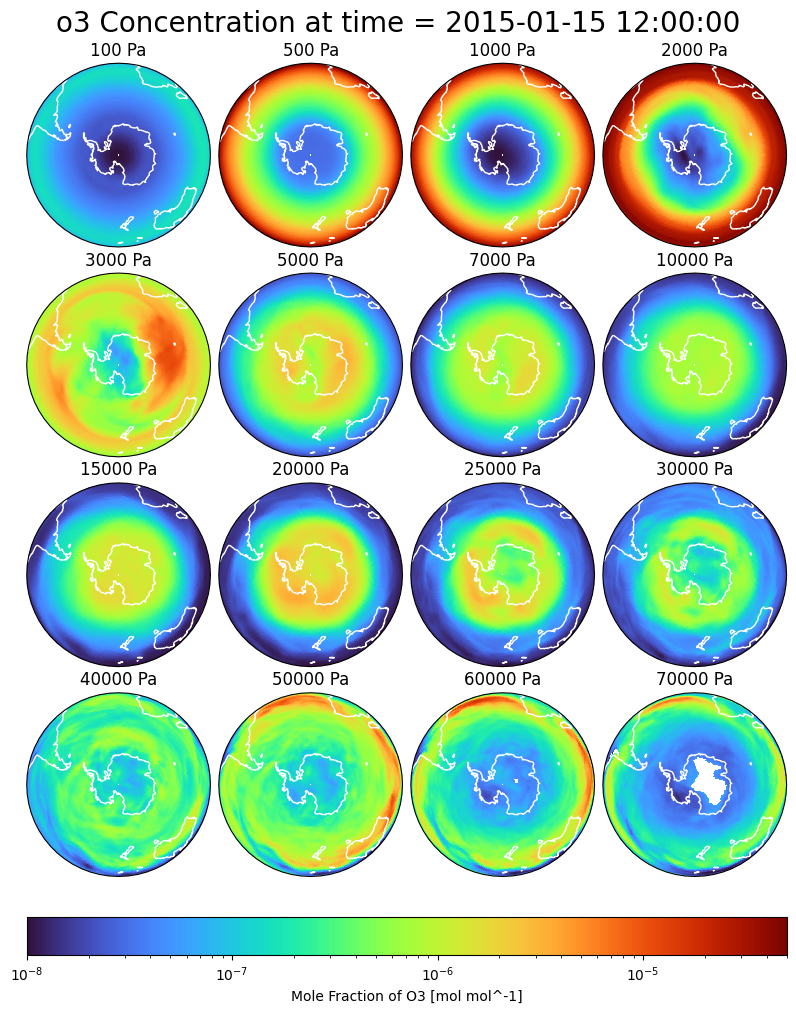

In [11]:
%%time

# at time = n, all plev (color plot), animated by time
fig, axs = plt.subplots(4,4, figsize=(8,10), layout='compressed', subplot_kw=
                        {'projection': ccrs.Orthographic(central_longitude=0.0, central_latitude=-90)})

frames = math.floor(ds.o3.time.size/2)
norm = mpl.colors.LogNorm(vmin=(10**-8), vmax=(5*10**-5))
cmap = 'turbo'

plt.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap), ax=axs, location='bottom', label="Mole Fraction of O3 [mol mol^-1]")

def update(num):
    lev=18
    for r, row in enumerate(axs):
        for c, ax in enumerate(row):
            ax.clear()
            ds.o3.isel(time=num, plev=lev).plot(ax=ax, transform=ccrs.PlateCarree(), cmap=cmap)
            ax.collections[-1].colorbar.remove()
            ax.set_title("%.f Pa" %ds.plev.isel(plev=lev).values)
            ax.coastlines(resolution='110m', color='w')
            lev -= 1
    fig.suptitle("o3 Concentration at time = %s" %ds.time.isel(time=num).values, size=20)


anim = FuncAnimation(fig=fig, func=update, frames=frames, interval=200, repeat=True)

anim.save("o3_subPlev_animTime.gif", writer='pillow')

CPU times: total: 15min 20s
Wall time: 18min 18s


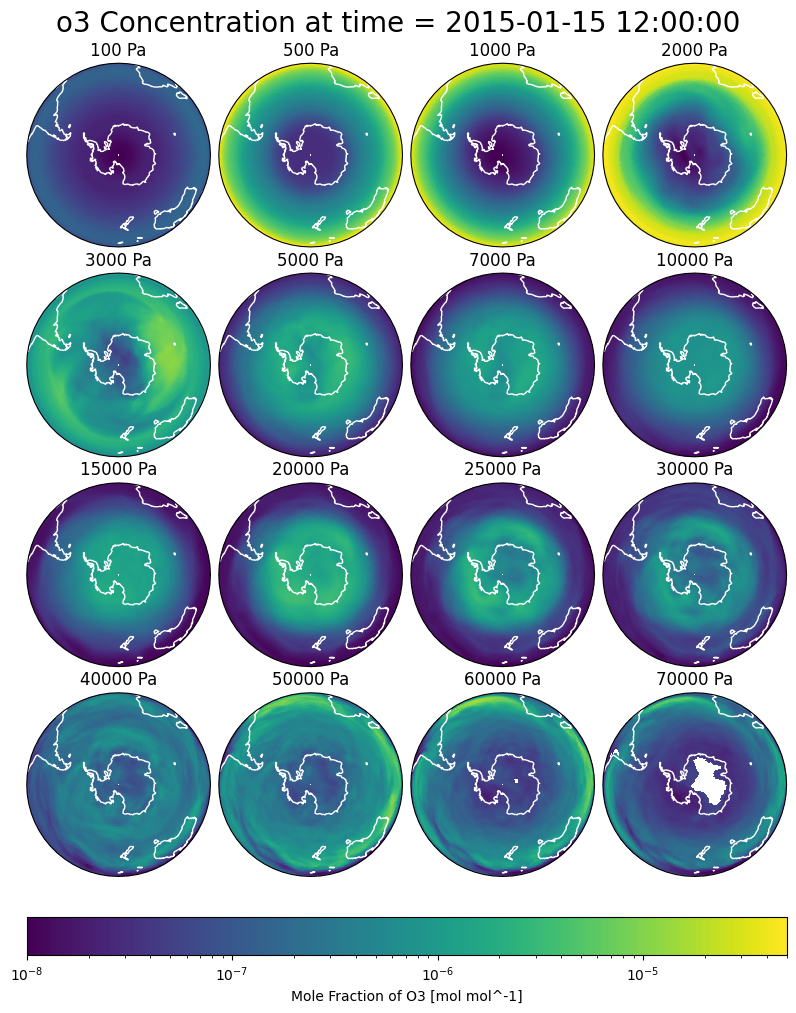

In [6]:
%%time

# at time = n, all plev (color plot), animated by time
fig, axs = plt.subplots(4,4, figsize=(8,10), layout='compressed', subplot_kw=
                        {'projection': ccrs.Orthographic(central_longitude=0.0, central_latitude=-90)})

frames = math.floor(ds.o3.time.size/2)
norm = mpl.colors.LogNorm(vmin=(10**-8), vmax=(5*10**-5))
cmap = 'viridis'

plt.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap), ax=axs, location='bottom', label="Mole Fraction of O3 [mol mol^-1]")

def update(num):
    lev=18
    for r, row in enumerate(axs):
        for c, ax in enumerate(row):
            ax.clear()
            ds.o3.isel(time=num, plev=lev).plot(ax=ax, transform=ccrs.PlateCarree(), cmap=cmap)
            ax.collections[-1].colorbar.remove()
            ax.set_title("%.f Pa" %ds.plev.isel(plev=lev).values)
            ax.coastlines(resolution='110m', color='w')
            lev -= 1
    fig.suptitle("o3 Concentration at time = %s" %ds.time.isel(time=num).values, size=20)


anim = FuncAnimation(fig=fig, func=update, frames=frames, interval=200, repeat=True)

anim.save("o3_subPlev_animTime.gif", writer='pillow')

# tests

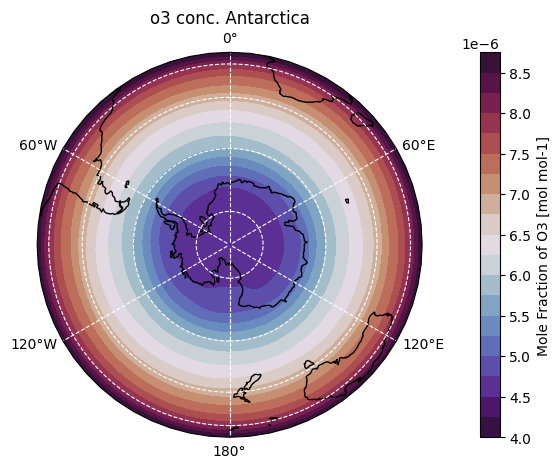

In [248]:
fig=plt.figure(figsize=[15,5])
ax=plt.axes(projection=ccrs.Orthographic(central_longitude=0.0, central_latitude=-90))

data = ds.o3.isel(time=0).sel(plev=500)
cbar_label = ds.o3.attrs['long_name'] + ' [' + ds.o3.attrs['units'] + ']'

# contour coloured map
data, lons = cutil.add_cyclic_point(data, coord=ds.lon) #else would be a white line in middle
cs = ax.contourf(lons, ds.lat, data, transform=ccrs.PlateCarree(), cmap='twilight_shifted', levels=20)
# cs = ax.contourf(ds.lon, ds.lat, data, transform=ccrs.PlateCarree())
plt.colorbar(cs, label = cbar_label)

# ax.set_extent([0,360, -90,-60], ccrs.PlateCarree()) #uncomment to zoom in on antarctica

ax.set_title("o3 conc. Antarctica")
ax.coastlines(color='k')
grid = ax.gridlines(ls='--', color='w', draw_labels=True)

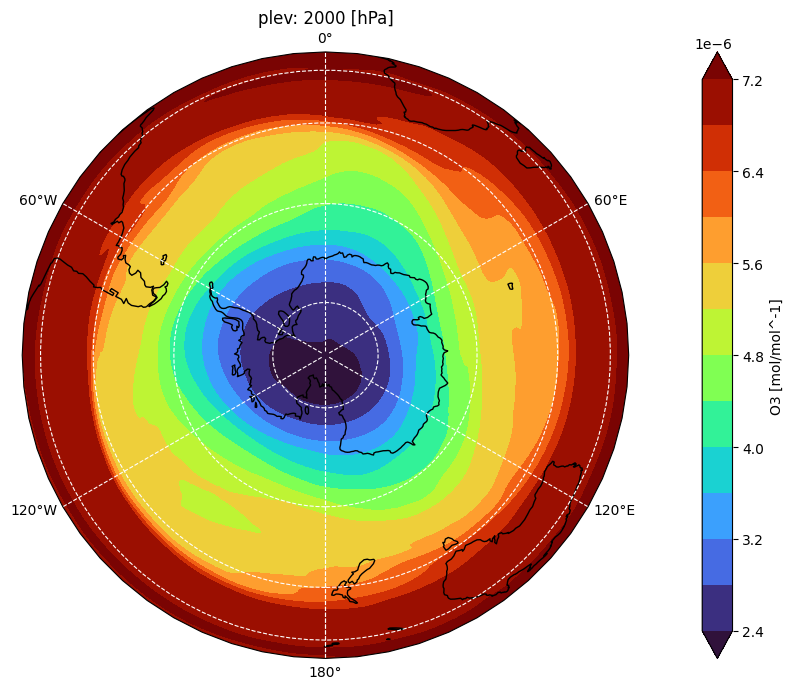

In [150]:
fig=plt.figure(figsize=(15,7), layout='tight')
ax=plt.axes(projection=ccrs.Orthographic(central_longitude=0, central_latitude=-90))
data, lons = cutil.add_cyclic_point(ds.o3.isel(time=2, plev=15), coord=ds.lon)
cs = ax.contourf(lons, ds.lat, data, cmap='turbo', extend='both', transform=ccrs.PlateCarree(), levels=12)
plt.colorbar(cs, label = 'O3 [mol/mol^-1]')
ax.set_title("plev: %.f [hPa]" %ds.plev.isel(plev=15).values)
ax.coastlines()
ax.gridlines(draw_labels=True, ls="--", color="w")
# ax.set_extent([0,360, -90,-50], ccrs.PlateCarree()) #uncomment to zoom in on antarctica

CPU times: total: 938 ms
Wall time: 932 ms


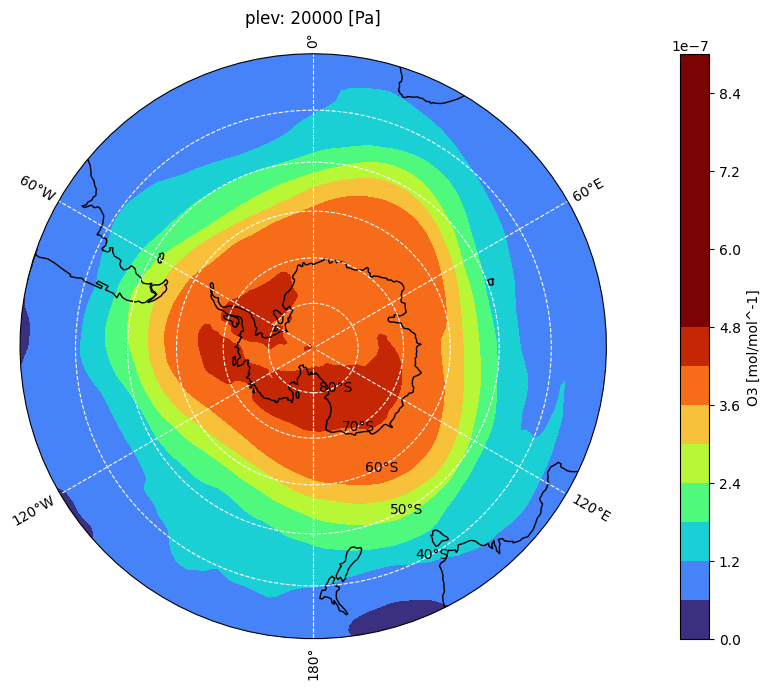

In [195]:
%%time
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpl.path.Path(verts * radius + center)

norm = mpl.colors.Normalize(vmin=(10**-8), vmax=(5*10**-7))

fig=plt.figure(figsize=(15,7), layout='tight')
ax=plt.axes(projection=ccrs.SouthPolarStereo(central_longitude=0))
data, lons = cutil.add_cyclic_point(ds.o3.isel(time=2, plev=9), coord=ds.lon)
cs = ax.contourf(lons, ds.lat, data, cmap='turbo', transform=ccrs.PlateCarree(), levels=15, norm=norm)
plt.colorbar(cs, label = 'O3 [mol/mol^-1]')
ax.set_title("plev: %.f [Pa]" %ds.plev.isel(plev=9).values)
ax.coastlines()
ax.gridlines(draw_labels=True, ls="--", color="w")
ax.set_extent([0,360, -90, -30], ccrs.PlateCarree()) #uncomment to zoom in on antarctica
ax.set_boundary(circle, transform=ax.transAxes)

CPU times: total: 1.44 s
Wall time: 1.46 s


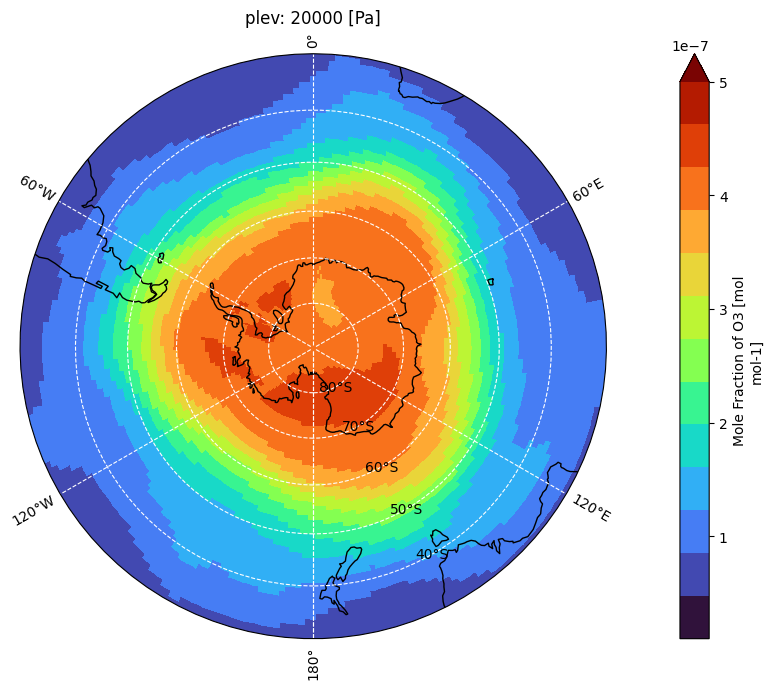

In [196]:
%%time
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpl.path.Path(verts * radius + center)

norm = mpl.colors.Normalize(vmin=(10**-8), vmax=(5*10**-7))

fig=plt.figure(figsize=(15,7), layout='tight')
ax=plt.axes(projection=ccrs.SouthPolarStereo(central_longitude=0))

ds.o3.isel(time=2, plev=9).plot(ax=ax, cmap='turbo', transform=ccrs.PlateCarree(), levels=15, norm=norm)

ax.set_title("plev: %.f [Pa]" %ds.plev.isel(plev=9).values)
ax.coastlines()
ax.gridlines(draw_labels=True, ls="--", color="w")
ax.set_extent([0,360, -90, -30], ccrs.PlateCarree()) #uncomment to zoom in on antarctica
ax.set_boundary(circle, transform=ax.transAxes)

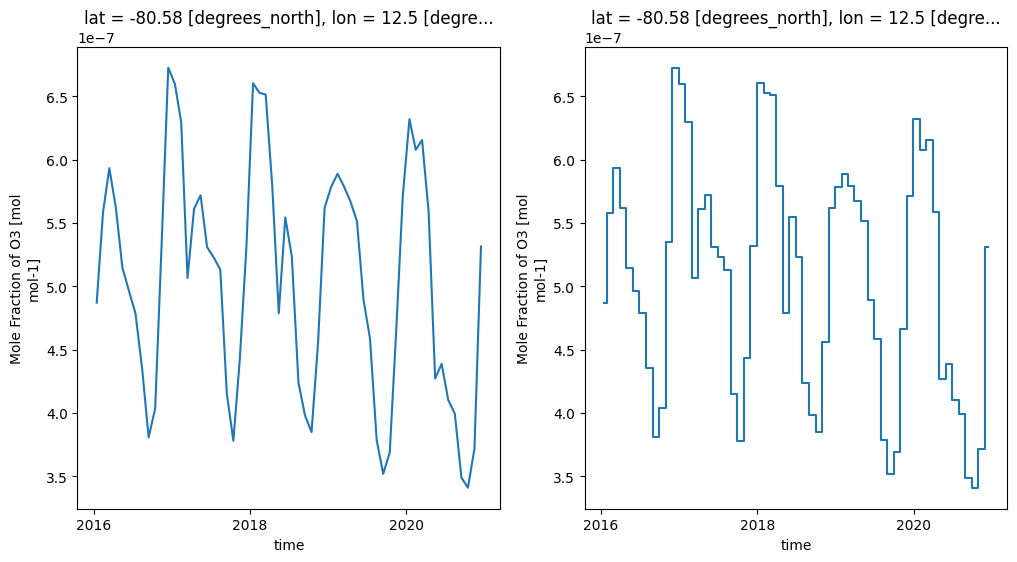

In [169]:
fig,(ax1,ax2) = plt.subplots(1,2,figsize=[12,6])
o3_ds = ds.o3.isel(lat=10, lon=10, plev=10)[12:72]
o3_ds.plot.line(x='time', ax=ax1)
o3_ds.plot.step(where='mid', ax=ax2)

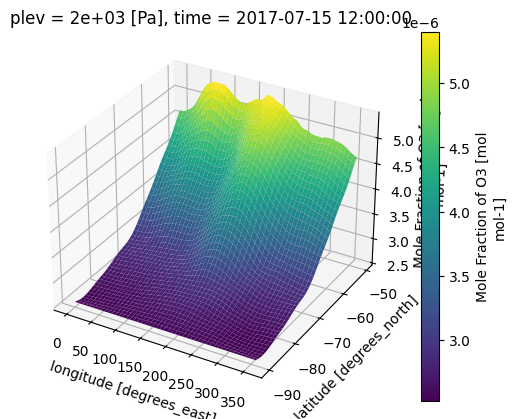

In [205]:
o3_2d = ds.o3.isel(time=30, plev=15).sel(lat=slice(-90,-50))
o3_2d.plot.surface(cmap='viridis')

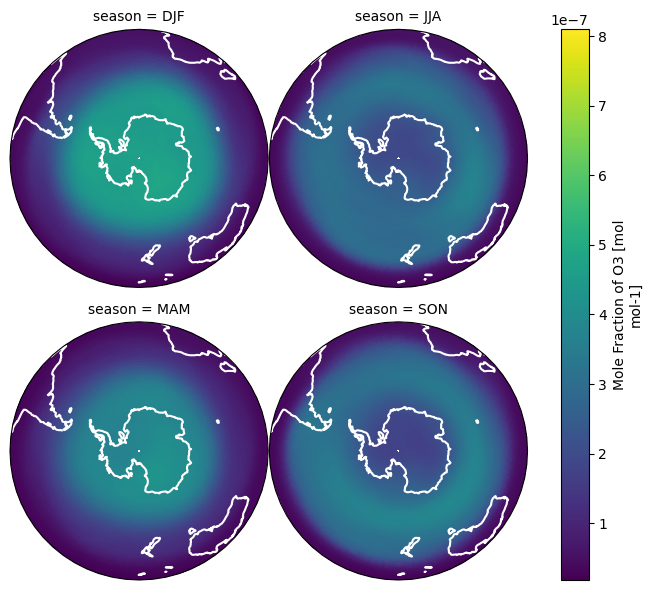

In [20]:
group = ds.o3.groupby('time.season').median(dim='time')
eee = group.isel(plev=9).plot(col='season', col_wrap=2, transform=ccrs.PlateCarree(), subplot_kws=
                              dict(projection=ccrs.Orthographic(central_longitude=0.0, central_latitude=-90)))

for ax in eee.axs.flat:
    # ax.gridlines(eg)
    # ax.set_extent((eg))
    ax.coastlines(color='w', lw=1.5, resolution='110m')
